In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
import pandas as pd

In [3]:
#data = pd.read_csv('/content/drive/My Drive/solar-forecasting/data/meteo_galicia.csv', sep=';', parse_dates=['fecha'], decimal=',',
#                 infer_datetime_format=True, low_memory=False, index_col='fecha').sort_index()

In [4]:
data = pd.read_csv('./data/meteo_galicia.csv', sep=';', parse_dates=['fecha'], decimal=',',
                 infer_datetime_format=True, low_memory=False, index_col='fecha').sort_index()

In [5]:
data

,estacionid,lat,lon,tamb,hum,pres,prec,rad,vvien,tipodered
fecha,,,,,,,,,,
2019-01-01 00:10:00,20284,42.4044,-8.6730,5.4,0,1022.0,0.0,0.0,0.7,OFICIAL
2019-01-01 00:10:00,20233,42.3554,-7.0086,7.3,0,892.1,0.0,0.0,3.5,OFICIAL
2019-01-01 00:10:00,20218,43.1626,-7.2826,9.2,0,955.0,0.0,0.0,0.0,OFICIAL
2019-01-01 00:10:00,20217,42.7071,-7.0471,8.5,0,882.5,0.0,1.0,6.3,OFICIAL
2019-01-01 00:10:00,20221,43.5407,-7.0830,5.3,0,1027.0,0.0,0.0,2.8,OFICIAL
...,...,...,...,...,...,...,...,...,...,...
2019-06-01 19:40:00,20249,42.2987,-7.5907,25.0,0,909.0,0.0,402.0,2.0,OFICIAL
2019-06-01 19:40:00,20259,42.1630,-7.0896,27.0,0,922.0,0.0,374.0,3.0,OFICIAL
2019-06-01 19:40:00,20255,42.4631,-6.9295,30.0,0,NaN,0.0,378.0,0.0,OFICIAL


In [6]:
data = data.drop(columns=['tipodered', 'hum'])

In [7]:
estaciones = [s for s in set(data['estacionid'])]

In [8]:
len(estaciones)

142

In [9]:
%%time
data_by_station = []

for s in estaciones:
    filter_station = data['estacionid'] == s
    data_station = data[filter_station].drop(columns=['estacionid', 'lat', 'lon'])
    d = data_station.describe()
    if d.rad['max'] != 0:
        data_by_station.append(data_station)

CPU times: user 3.74 s, sys: 58.3 ms, total: 3.8 s
Wall time: 3.9 s


In [10]:
len(data_by_station)

111

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize': (16, 6)})

In [12]:
data_train = data_by_station[0]

In [13]:
data_train

,tamb,pres,prec,rad,vvien
fecha,,,,,
2019-01-01 01:00:00,11.6,1017.0,0.0,0.0,1.0
2019-01-01 01:10:00,10.9,1017.0,0.0,0.0,0.7
2019-01-01 01:30:00,10.3,1016.9,0.0,0.0,1.3
2019-01-01 01:40:00,10.0,1016.9,0.0,0.0,1.7
2019-01-01 02:00:00,10.2,1017.0,0.0,0.0,0.8
...,...,...,...,...,...
2019-06-01 18:30:00,27.0,1003.0,0.0,578.0,1.0
2019-06-01 18:40:00,26.0,1003.0,0.0,544.0,2.0
2019-06-01 19:00:00,26.0,1003.0,0.0,471.0,2.0


In [14]:
data_train = data_train.resample('30T').mean().ffill()

In [15]:
data_train = data_train.drop(columns=['prec', 'vvien'])

In [16]:
data_train

,tamb,pres,rad
fecha,,,
2019-01-01 01:00:00,11.25,1017.00,0.0
2019-01-01 01:30:00,10.15,1016.90,0.0
2019-01-01 02:00:00,10.30,1017.00,0.0
2019-01-01 02:30:00,10.40,1017.10,0.0
2019-01-01 03:00:00,9.45,1017.25,0.0
...,...,...,...
2019-06-01 17:30:00,25.50,1004.00,640.0
2019-06-01 18:00:00,26.00,1003.00,632.0
2019-06-01 18:30:00,26.50,1003.00,561.0


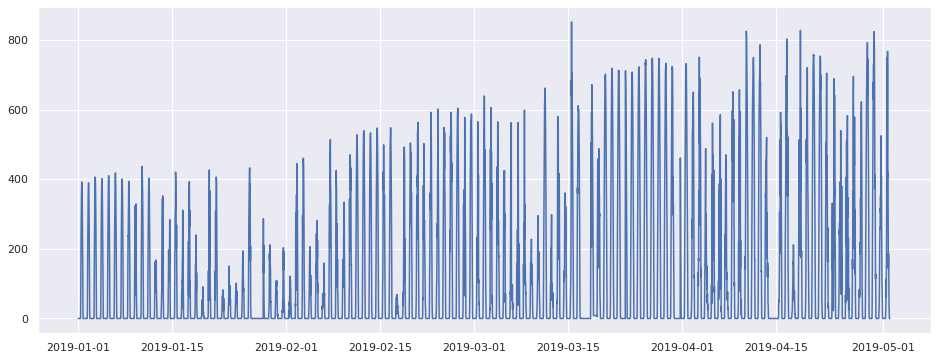

In [17]:
data_train = data_train.loc[:'2019-05-01']

plt.plot(data_train['rad'])
plt.show()

# II Preparación del conjunto de datos para el entrenamiento de una red neuronal recurrente.

In [18]:
import numpy as np
import tensorflow as tf

np.random.seed(1)
tf.random.set_seed(1)

In [19]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    
    return agg

def get_rnn_dataset(data, past_history=10, forecast_horizon=1):
    n_vars = data.shape[1]
    values = series_to_supervised(data, past_history, forecast_horizon).values
    train_X, train_y = values[:, :-1*n_vars*forecast_horizon], values[:, n_vars*past_history+2::n_vars]
    
    return train_X, train_y

In [20]:
one_day_min = 24*60

interval_min = 30
past_day = 7
forecast_day = 1

past_history = int((one_day_min / interval_min) * past_day)
forecast_horizon = int((one_day_min / interval_min) * forecast_day)

print("Past history {0} , {1} day".format(past_history, past_day))
print("Forecast horizon {0} , {1} day".format(forecast_horizon, forecast_day))

Past history 336 , 7 day
Forecast horizon 48 , 1 day


In [21]:
class Scaler:
    def fit(self, data):
        self._min = data.min()
        self._max = data.max()
    
    def normalize(self, data):
        return (data - self._min) / (self._max - self._min)
    
    def denormalize(self, data):
        return data*(self._max-self._min)+self._min

In [22]:
### TRAIN
tamb_scaler = Scaler()
tamb_scaler.fit(data_train['tamb'])

pres_scaler = Scaler()
pres_scaler.fit(data_train['pres'])

rad_scaler = Scaler()
rad_scaler.fit(data_train['rad'])

In [23]:
data_train = data_train.values

In [24]:
#data_train[:, 0] = tamb_scaler.normalize(data_train[:, 0])
#data_train[:, 1] = pres_scaler.normalize(data_train[:, 1])
#data_train[:, 2] = rad_scaler.normalize(data_train[:, 2])

In [25]:
data_test = data_by_station[1]
data_test = data_test.resample('30T').mean().ffill()
data_test = data_test.drop(columns=['prec', 'vvien'])
data_test = data_test.loc[:'2019-05-01']

## TEST
tamb_scaler_t = Scaler()
tamb_scaler_t.fit(data_test['tamb'])

pres_scaler_t = Scaler()
pres_scaler_t.fit(data_test['pres'])

rad_scaler_t = Scaler()
rad_scaler_t.fit(data_test['rad'])

data_test = data_test.values

#data_test[:, 0] = tamb_scaler_t.normalize(data_test[:, 0])
#data_test[:, 1] = pres_scaler_t.normalize(data_test[:, 1])
#data_test[:, 2] = rad_scaler_t.normalize(data_test[:, 2])

In [26]:
%%time
data, labels = get_rnn_dataset(data_train, past_history=past_history, forecast_horizon=forecast_horizon)
data_test, labels_test = get_rnn_dataset(data_test, past_history=past_history, forecast_horizon=forecast_horizon)

CPU times: user 230 ms, sys: 103 ms, total: 333 ms
Wall time: 334 ms


In [27]:
data.shape, data_test.shape

((5423, 1008), (5425, 1008))

In [28]:
data[:,2]

array([0., 0., 0., ..., 0., 0., 0.])

In [29]:
labels

array([[0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 1.5, 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ]])

In [30]:
def plot_result(x, y, y_pred=None):
    fig, ax = plt.subplots(1, 1, figsize=(15,5))
    ax.plot(x[2::3], 'o-', c='steelblue', ms=3.5, label='History')
    ax.plot([m for m in range(int(x.shape[0]/3), 
                              int(x.shape[0]/3+y.shape[0]))], y, 'x-', c='mediumseagreen', ms=3.5, label='Target')
    
    if y_pred is not None:
        ax.plot([m for m in range(int(x.shape[0]/3), 
                              int(x.shape[0]/3+y.shape[0]))], y_pred, 'o-', c='salmon', ms=3.5, label='Predict')
        
    ax.legend()

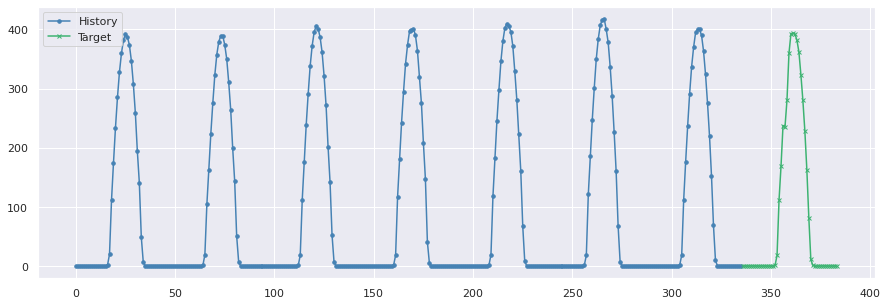

In [31]:
plot_result(data[0], labels[0])

# III Construcción del modelo

In [32]:
import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.losses import mae
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

### FF

In [33]:
model = Sequential([
    Dense(500, input_dim=data.shape[1]),
    Dense(forecast_horizon)
])

model.compile(loss='mae', optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 500)               504500    
_________________________________________________________________
dense_1 (Dense)              (None, 48)                24048     
Total params: 528,548
Trainable params: 528,548
Non-trainable params: 0
_________________________________________________________________


In [34]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
earlyStopping = EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True)

In [35]:
%%time
history = model.fit(data, labels, epochs=100, 
                    validation_data=(data_test, labels_test), 
                    verbose=0, callbacks=[earlyStopping, tensorboard_callback])

Instructions for updating:
use `tf.profiler.experimental.stop` instead.
CPU times: user 2min 30s, sys: 1min 51s, total: 4min 21s
Wall time: 1min 16s


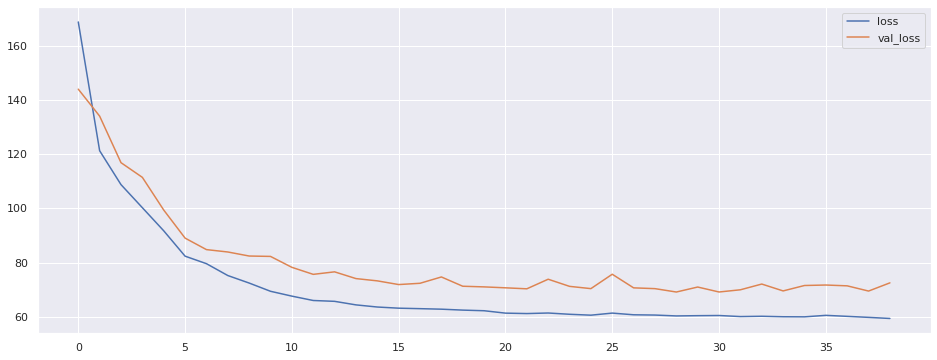

In [36]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [37]:
%%time
y_pred = model.predict(data_test)

CPU times: user 1.24 s, sys: 1.03 s, total: 2.27 s
Wall time: 732 ms


MAE: 69.12030029296875


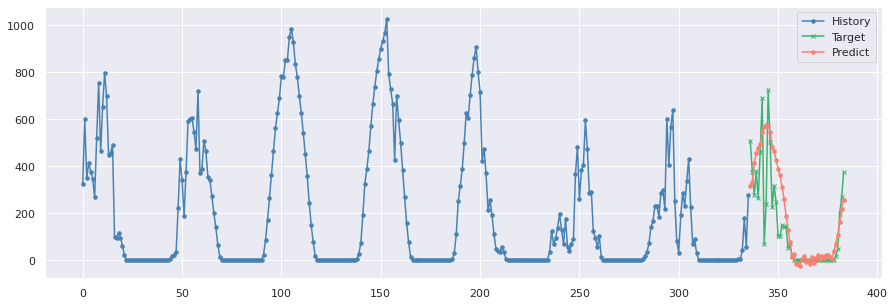

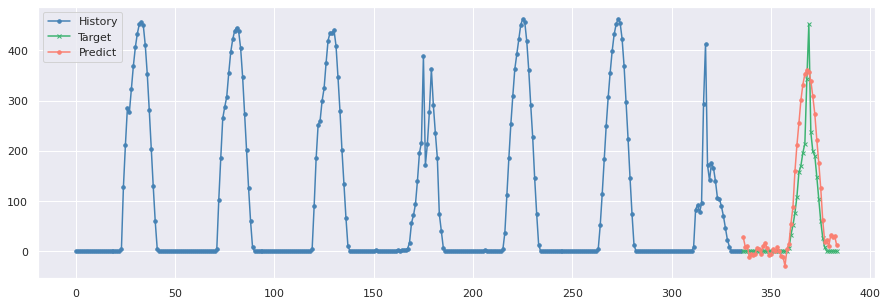

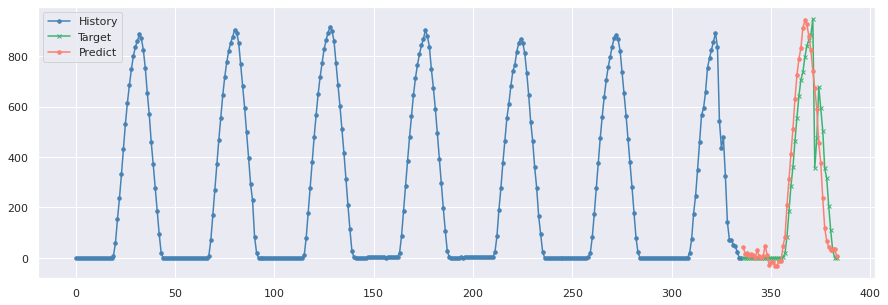

In [38]:
#yp = rad_scaler_t.denormalize(y_pred)
#y = rad_scaler_t.denormalize(labels_test)
#x = rad_scaler_t.denormalize(data_test)

yp = y_pred
y = labels_test
x = data_test

error = np.mean(mae(y, yp))

print("MAE: {}".format(error))

for _ in range(3):
    i = np.random.randint(len(data_test))
    plot_result(x[i], y[i], yp[i])